49/49 [==============================] - 21s 285ms/step - loss: 0.7361 - accuracy: 0.5160
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.025595475>
782/782 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_____________________________________________________

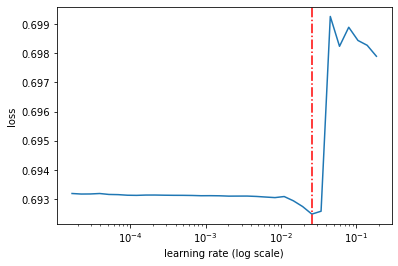

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from lrfinder import LRFinder
import matplotlib.pyplot as plt

K = tf.keras.backend

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = ""
num_epochs=1

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) 
tokenizer.fit_on_texts(training_sentences) 
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences) 
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

BATCH = 512
train_ds = tf.data.Dataset.from_tensor_slices((padded, training_labels_final))
train_ds = train_ds.batch(BATCH)
STEPS_PER_EPOCH = np.ceil(len(train_data) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(train_ds, start_lr=1e-6, end_lr=1, epochs=num_epochs,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

def plot_loss(learning_rates, losses, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

axs = plot_loss(learning_rates=learning_rates,losses=losses)
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')

best_lr = lr_finder.get_best_lr(sma=20)
K.set_value(model.optimizer.lr, best_lr)
print(model.optimizer.lr)


earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001, patience=1)

model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), callbacks=[earlystop_callback])
model.evaluate(testing_padded)
